In [1]:
import json
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


In [24]:
def analyze_patient_predictions_with_df(
    df_patient_data: pd.DataFrame,
    json_results_path: str,
    classifier_name: str,
    patient_id_col_in_patient_data: str = 'pseudo_provisoire',
    geo_col: str = 'CODE_DEPT',
    air_quality_col: str = 'max_NO2_J_31',
    age_col: str = 'age_at_event',
    age_cat_col: str = 'cat_age',
    cluster_col: str = 'cluster'
) -> dict:
    """
    Performs a comprehensive analysis of patient prediction outcomes based on a given
    classifier, integrating classification results with detailed patient data.
    Plots for categorical features (geo, age_cat, cluster) will now show relative percentages
    of 'Well Predicted' vs 'Poorly Predicted' within each category.

    Args:
        df_patient_data (pd.DataFrame): The DataFrame containing patient demographic
                                        and environmental data.
        json_results_path (str): Path to the JSON file containing ML prediction results.
        classifier_name (str): The exact name of the classifier (e.g., 'BalancedRandomForestClassifier')
                               to analyze from the JSON results.
        patient_id_col_in_patient_data (str): The column name in the patient data DataFrame
                                                that contains the patient IDs, matching those in JSON.
                                                Defaults to 'pseudo_provisoire'.
        geo_col (str): Column name for geographical identification (e.g., 'CODE_DEPT').
        air_quality_col (str): Column name for air quality data (e.g., 'max_PM25_J_0').
        age_col (str): Column name for numerical age data (e.g., 'age_at_event').
        age_cat_col (str): Column name for categorical age data (e.g., 'cat_age').
        cluster_col (str): Column name for patient cluster data (e.g., 'cluster').

    Returns:
        dict: A dictionary containing the merged DataFrame and analysis summaries.
    """
    analysis_results = {}

    # Make a copy to avoid modifying the original DataFrame passed in
    df_patient_data_copy = df_patient_data.copy()

    # --- Robust Patient ID Column Handling ---
    # Check if the specified patient ID column exists
    if patient_id_col_in_patient_data not in df_patient_data_copy.columns:
        print(f"Error: Patient ID column '{patient_id_col_in_patient_data}' not found in the patient data DataFrame.")
        return analysis_results

    # Ensure the patient ID column is consistently named 'Patient_ID'
    # Create a new 'Patient_ID' column by copying the content of the specified ID column
    df_patient_data_copy['Patient_ID'] = df_patient_data_copy[patient_id_col_in_patient_data]

    # If the original patient ID column was different from 'Patient_ID', drop the original
    if patient_id_col_in_patient_data != 'Patient_ID':
        df_patient_data_copy.drop(columns=[patient_id_col_in_patient_data], inplace=True)
    # --- End Robust Patient ID Column Handling ---

    # 1. Load ML Results
    try:
        with open(json_results_path, 'r') as file:
            results_ml = json.load(file)
    except FileNotFoundError:
        print(f"Error: ML results JSON file not found at {json_results_path}")
        return analysis_results
    except json.JSONDecodeError:
        print(f"Error: Could not decode JSON from {json_results_path}. Check file format.")
        return analysis_results

    df_true_positives = pd.DataFrame()
    df_true_negatives = pd.DataFrame()
    df_false_positives = pd.DataFrame()
    df_false_negatives = pd.DataFrame()

    if 'global' in results_ml and \
       classifier_name in results_ml['global'] and \
       'patient_classification_breakdown' in results_ml['global'][classifier_name]:

        classifier_data = results_ml['global'][classifier_name]
        breakdown_data = classifier_data['patient_classification_breakdown']

        true_positives_ids = breakdown_data.get('true_positives_patients_ids', [])
        true_negatives_ids = breakdown_data.get('true_negatives_patients_ids', [])
        false_positives_ids = breakdown_data.get('false_positives_patients_ids', [])
        false_negatives_ids = breakdown_data.get('false_negatives_patients_ids', [])

        df_true_positives = pd.DataFrame({'Patient_ID': true_positives_ids, 'Classification': 'True Positive'})
        df_true_negatives = pd.DataFrame({'Patient_ID': true_negatives_ids, 'Classification': 'True Negative'})
        df_false_positives = pd.DataFrame({'Patient_ID': false_positives_ids, 'Classification': 'False Positive'})
        df_false_negatives = pd.DataFrame({'Patient_ID': false_negatives_ids, 'Classification': 'False Negative'})
    else:
        print(f"Warning: '{classifier_name}' or its patient classification breakdown was not found in the ML results. Proceeding without specific classification breakdowns.")

    # 2. Merge Classification Results with Patient Data
    all_predictions_df = pd.concat([
        df_true_positives,
        df_true_negatives,
        df_false_positives,
        df_false_negatives
    ])

    # Filter patient data to include only those present in the prediction results
    # This line should now work because 'Patient_ID' is guaranteed to exist in df_patient_data_copy
    df_patients_filtered = df_patient_data_copy[df_patient_data_copy['Patient_ID'].isin(all_predictions_df['Patient_ID'])].copy()
    df_predicted = all_predictions_df.copy()

    df_analyzable_patients = pd.merge(df_patients_filtered, df_predicted, on='Patient_ID', how='left')
    df_analyzable_patients['Classification'] = df_analyzable_patients['Classification'].fillna('Not Classified')
    df_analyzable_patients['Prediction_Quality'] = df_analyzable_patients['Classification'].apply(
        lambda x: 'Well Predicted' if x in ['True Positive', 'True Negative'] else 'Poorly Predicted'
    )
    analysis_results['merged_data'] = df_analyzable_patients
    print("\n--- Merged Patient Data with Classifications ---")
    print(df_analyzable_patients.head())

    # 3. Analysis and Visualization
    print(f"\n--- Analysis for Classifier: {classifier_name} ---")

    # Overall Prediction Quality
    print("\nOverall Prediction Quality Distribution:")
    pred_quality_counts = df_analyzable_patients['Prediction_Quality'].value_counts(normalize=True) * 100
    print(pred_quality_counts.round(2)) # Display as percentage
    analysis_results['overall_prediction_quality_percentage'] = pred_quality_counts

    # Geographical Distribution (with percentages)
    if geo_col in df_analyzable_patients.columns:
        print(f"\nGeographical Distribution ({geo_col}) by Prediction Quality (Percentages):")
        # Calculate counts for each combination
        geo_dist_counts = df_analyzable_patients.groupby([geo_col, 'Prediction_Quality']).size().unstack(fill_value=0)
        # Calculate percentages within each geographical group
        # Avoid division by zero if a category has no patients
        geo_dist_pct = geo_dist_counts.div(geo_dist_counts.sum(axis=1).replace(0, 1), axis=0) * 100
        print(geo_dist_pct.head().round(2))
        analysis_results['geo_distribution_percentage'] = geo_dist_pct

        if not geo_dist_pct.empty:
            plt.figure(figsize=(15, 7))
            # Plot top 10 communes by total patient count for better visualization
            # Ensure top_n_communes is not empty before indexing
            total_patient_counts_by_geo = df_analyzable_patients[geo_col].value_counts()
            if not total_patient_counts_by_geo.empty:
                top_n_communes = total_patient_counts_by_geo.nlargest(10).index
                # Filter geo_dist_pct to only include top_n_communes that are actually in its index
                plot_data = geo_dist_pct.loc[geo_dist_pct.index.intersection(top_n_communes)]
                if not plot_data.empty:
                    plot_data.plot(kind='bar', stacked=False, ax=plt.gca()) # Stacked makes sense for percentages
                    plt.title(f'Prediction Quality by Top 10 {geo_col} for {classifier_name} (Percentages)')
                    plt.ylabel('Percentage of Patients (%)')
                    plt.xlabel(geo_col)
                    plt.xticks(rotation=45, ha='right')
                    plt.legend(title='Prediction Quality')
                    plt.tight_layout()
                    plt.show()
                else:
                    print(f"No data to plot for top 10 {geo_col} after filtering.")
            else:
                print(f"No patient counts found for {geo_col} to determine top 10.")
        else:
            print(f"No geographical distribution data to plot for {classifier_name}.")
    else:
        print(f"Warning: Geographical column '{geo_col}' not found in patient data DataFrame.")

    # Air Quality Analysis (numerical, so box plots remain)
    if air_quality_col in df_analyzable_patients.columns:
        print(f"\nMedian {air_quality_col} by Prediction Quality:")
        avg_air_quality_by_pred_quality = df_analyzable_patients.groupby('Prediction_Quality')[air_quality_col].median()
        print(avg_air_quality_by_pred_quality.round(2))
        analysis_results['median_air_quality_by_pred_quality'] = avg_air_quality_by_pred_quality

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Prediction_Quality', y=air_quality_col, data=df_analyzable_patients)
        plt.title(f'Distribution of {air_quality_col} by Prediction Quality for {classifier_name}')
        plt.ylabel(air_quality_col)
        plt.xlabel('Prediction Quality')
        plt.show()

        print(f"\nMedian {air_quality_col} by specific Classification types (TP, TN, FP, FN):")
        avg_air_quality_by_classification = df_analyzable_patients.groupby('Classification')[air_quality_col].median()
        print(avg_air_quality_by_classification.round(2))
        analysis_results['median_air_quality_by_classification'] = avg_air_quality_by_classification

        plt.figure(figsize=(12, 7))
        sns.boxplot(x='Classification', y=air_quality_col, data=df_analyzable_patients)
        plt.title(f'Distribution of {air_quality_col} by Classification Type for {classifier_name}')
        plt.ylabel(air_quality_col)
        plt.xlabel('Classification Type')
        plt.show()

    else:
        print(f"Warning: Air quality column '{air_quality_col}' not found in patient data DataFrame.")

    # Age Analysis (Numerical - box plots remain)
    if age_col in df_analyzable_patients.columns:
        print(f"\nAverage {age_col} by Prediction Quality:")
        avg_age_by_pred_quality = df_analyzable_patients.groupby('Prediction_Quality')[age_col].mean()
        print(avg_age_by_pred_quality.round(2))
        analysis_results['avg_age_by_pred_quality'] = avg_age_by_pred_quality

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Prediction_Quality', y=age_col, data=df_analyzable_patients)
        plt.title(f'Distribution of {age_col} by Prediction Quality for {classifier_name}')
        plt.ylabel(age_col)
        plt.xlabel('Prediction Quality')
        plt.show()

    else:
        print(f"Warning: Numerical age column '{age_col}' not found in patient data DataFrame.")

    # Age Analysis (Categorical - with percentages)
    if age_cat_col in df_analyzable_patients.columns:
        print(f"\n{age_cat_col} Distribution by Prediction Quality (Percentages):")
        age_cat_dist_counts = df_analyzable_patients.groupby([age_cat_col, 'Prediction_Quality']).size().unstack(fill_value=0)
        age_cat_dist_pct = age_cat_dist_counts.div(age_cat_dist_counts.sum(axis=1).replace(0, 1), axis=0) * 100
        print(age_cat_dist_pct.round(2))
        analysis_results['age_cat_distribution_percentage'] = age_cat_dist_pct

        if not age_cat_dist_pct.empty:
            age_cat_dist_pct.plot(kind='bar', figsize=(12, 6), stacked=False)
            plt.title(f'{age_cat_col} Distribution by Prediction Quality for {classifier_name} (Percentages)')
            plt.ylabel('Percentage of Patients (%)')
            plt.xlabel(age_cat_col)
            plt.xticks(rotation=45, ha='right')
            plt.legend(title='Prediction Quality')
            plt.tight_layout()
            plt.show()
        else:
            print(f"No categorical age distribution data to plot for {classifier_name}.")
    else:
        print(f"Warning: Categorical age column '{age_cat_col}' not found in patient data DataFrame.")

    # Cluster Analysis (with percentages)
    if cluster_col in df_analyzable_patients.columns:
        print(f"\n{cluster_col} Distribution by Prediction Quality (Percentages):")
        cluster_dist_counts = df_analyzable_patients.groupby([cluster_col, 'Prediction_Quality']).size().unstack(fill_value=0)
        cluster_dist_pct = cluster_dist_counts.div(cluster_dist_counts.sum(axis=1).replace(0, 1), axis=0) * 100
        print(cluster_dist_pct.round(2))
        analysis_results['cluster_distribution_percentage'] = cluster_dist_pct

        if not cluster_dist_pct.empty:
            cluster_dist_pct.plot(kind='bar', figsize=(12, 6), stacked=False)
            plt.title(f'{cluster_col} Distribution by Prediction Quality for {classifier_name} (Percentages)')
            plt.ylabel('Percentage of Patients (%)')
            plt.xlabel(cluster_col)
            plt.xticks(rotation=45, ha='right')
            plt.legend(title='Prediction Quality')
            plt.tight_layout()
            plt.show()
        else:
            print(f"No cluster distribution data to plot for {classifier_name}.")
    else:
        print(f"Warning: Cluster column '{cluster_col}' not found in patient data DataFrame.")

    return analysis_results


In [49]:
# Lire un fichier json


with open(r'C:\experiments\rigorous_ml\20250818_120437\all_metrics_20250818_120437.json', 'r') as file:
    results_ml = json.load(file)

df_clusters = pd.read_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_clusters.csv", sep=";")
df_patients = pd.read_csv(r"data/data_cleaned/patients_FR_IDF_geocoded_adultes_clinique_patho_statut_deces_apres_2017.csv", sep=",")

df_pca = pd.read_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_pca.csv", sep=";")

C:\Users\lpokambo\AppData\Local\Temp\ipykernel_20296\3452449734.py:7: DtypeWarning: Columns (166) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clusters = pd.read_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_clusters.csv", sep=";")
C:\Users\lpokambo\AppData\Local\Temp\ipykernel_20296\3452449734.py:10: DtypeWarning: Columns (166) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pca = pd.read_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_pca.csv", sep=";")


In [5]:
# sample = pd.read_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_clusters.csv", sep=";", nrows=100)
# print(sample.iloc[:, 166].unique())


In [50]:
df_clusters

,pseudo_provisoire,date_ref,max_PM25_J_0,nb_pics_PM25_J_0_WHO,pic_PM25_J_0_WHO,max_PM10_J_0,nb_pics_PM10_J_0_EU,pic_PM10_J_0_EU,nb_pics_PM10_J_0_WHO,pic_PM10_J_0_WHO,...,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,cluster
0,60,2019-10-03,11.500,0,0,23.88,0,0,0,0,...,0.081071,0.175579,0.227889,-0.080266,-0.081654,0.271404,-0.256264,0.321425,-0.147229,2.0
1,134,2019-09-07,5.688,0,0,10.44,0,0,0,0,...,-0.244214,0.525225,0.457276,0.611441,-0.259946,0.788037,-0.227431,0.425037,-0.092103,2.0
2,195,2019-01-08,7.750,0,0,14.19,0,0,0,0,...,0.145995,0.344253,0.070230,0.414569,-0.052943,0.308208,0.158029,-0.618473,-0.137780,3.0
3,197,2019-04-24,6.625,0,0,15.44,0,0,0,0,...,0.046457,0.122034,-0.324211,0.699416,-0.534742,-0.256719,-0.274063,-0.424156,-0.368075,1.0
4,200,2017-12-30,4.062,0,0,7.25,0,0,0,0,...,0.238673,-0.231384,0.701089,-0.569237,-0.327989,0.005846,-0.200000,-0.009884,-0.115177,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44263,64286,2018-12-31,8.125,0,0,11.00,0,0,0,0,...,-0.184093,-0.249026,-0.315269,-0.080744,-0.154864,0.305137,-0.386559,0.186088,0.041201,3.0
44264,64290,2018-11-05,18.880,1,1,25.88,0,0,0,0,...,0.001878,-0.284547,-0.709560,0.159487,-0.032567,-0.618390,0.182304,-0.124632,-0.144612,3.0
44265,64292,2019-11-10,12.060,0,0,13.94,0,0,0,0,...,0.001336,0.131845,-0.080134,-0.032962,-0.020816,-0.100567,0.102234,-0.151667,0.197309,2.0
44266,64293,2019-10-30,17.310,1,1,24.31,0,0,0,0,...,-0.150661,-0.218088,-0.248049,-0.028193,-0.045297,0.138487,-0.204631,-0.055626,-0.217265,2.0


In [51]:
df_patients

,pseudo_provisoire,adresse,codepost,nom_commune_postal,requete,x,y,score,trust_score,street,...,cancernum,date_diag,topo_initiale_cim10,topo_initialelib,patho,patient_co,date_naissance_y,date_derniere_nouvelle,statut_deces,statut_deces_a_letude
0,1,34 RUE DES FRERES CHAUSSONS,92600.0,ASNIERES-SUR-SEINE,34 RUE DES FRERES CHAUSSONS 92600 ASNI...,2.289499,48.916298,0.832367,middle,34 Rue des Frères Chausson,...,1.0,2018-04-30,C92,Leucémie myéloïde aiguë,Hemato,10174,1985-06,2018-07-18,non,non
1,2,11 RUE EMILE DUBOIS,75014.0,PARIS,11 RUE EMILE DUBOIS 75014 PARIS,2.336628,48.831707,0.972567,high,11 Rue Emile Dubois,...,1.0,2017-07-17,C69,Tumeur maligne de la choroïde,Ophtalmo,10892,1970-10,2023-08-10,non,non
2,3,48 CHEMIN VERT,78680.0,EPONE,48 CHEMIN VERT 78680 EPONE,1.797376,48.950412,0.960861,high,48 Chemin Vert,...,1.0,2019-01-15,C61,Tumeur maligne de la prostate,Uro,8628,1949-03,2019-10-09,non,non
3,5,31 RUE DU GENERAL DE MIRIBEL,92500.0,RUEIL-MALMAISON,31 RUE DU GENERAL DE MIRIBEL 92500 RUEI...,2.173326,48.865232,0.973612,high,31 Rue du Général de Miribel,...,1.0,2018-02-22,C61,Tumeur maligne de la prostate,Uro,10174,1941-12,2024-01-15,non,non
4,6,124 RUE JEAN BAPTISTE CHARCOT,92400.0,COURBEVOIE,124 RUE JEAN BAPTISTE CHARCOT 92400 COUR...,2.273851,48.900542,0.978121,high,124 Rue Jean-Baptiste Charcot,...,1.0,2018-07-03,C50,Tumeur maligne à localisations contiguës du sein,Sein,10174,1968-03,2021-09-14,non,non
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44263,64286,15 RUE HOUSSA OUAID,77500.0,CHELLES,15 RUE HOUSSA OUAID 77500 CHELLES,2.571635,48.869009,0.803830,middle,15 Rue Houssa Ouïd,...,1.0,2004-06-28,C50,Tumeur maligne du mamelon et de l aréole,Sein,3018,1952-09,2023-05-12,oui,non
44264,64290,3 AV DE FOUILLEUSE,92210.0,SAINT-CLOUD,3 AV DE FOUILLEUSE 92210 SAIN...,2.211229,48.861208,0.749249,middle,3 Avenue de Fouilleuse,...,1.0,2015-06-15,C82,Autres formes de lymphome non hodgkinien folli...,Hemato,10174,1942-06,2024-04-17,non,non
44265,64292,60 RUE BAUDRICOURT,75013.0,Paris 13,60 RUE BAUDRICOURT 75013 Pari...,2.362960,48.825882,0.811235,middle,60 Rue Baudricourt,...,1.0,1998-06-09,C50,Tumeur maligne à localisations contiguës du sein,Sein,10892,1944-11,2024-03-20,non,non
44266,64293,159 AVENUE DE LA REPUBLIQUE,92320.0,CHATILLON,159 AVENUE DE LA REPUBLIQUE 92320 CHAT...,2.300784,48.809219,0.970667,high,159 Avenue de la République,...,1.0,2000-11-20,C50,Tumeur maligne du quadrant supéro-externe du sein,Sein,10174,1946-09,2024-05-23,non,non


In [52]:
df_patients = df_patients.merge(df_clusters[['pseudo_provisoire', 'cluster']], on='pseudo_provisoire', how='left')

In [53]:
df_patients

,pseudo_provisoire,adresse,codepost,nom_commune_postal,requete,x,y,score,trust_score,street,...,date_diag,topo_initiale_cim10,topo_initialelib,patho,patient_co,date_naissance_y,date_derniere_nouvelle,statut_deces,statut_deces_a_letude,cluster
0,1,34 RUE DES FRERES CHAUSSONS,92600.0,ASNIERES-SUR-SEINE,34 RUE DES FRERES CHAUSSONS 92600 ASNI...,2.289499,48.916298,0.832367,middle,34 Rue des Frères Chausson,...,2018-04-30,C92,Leucémie myéloïde aiguë,Hemato,10174,1985-06,2018-07-18,non,non,2.0
1,2,11 RUE EMILE DUBOIS,75014.0,PARIS,11 RUE EMILE DUBOIS 75014 PARIS,2.336628,48.831707,0.972567,high,11 Rue Emile Dubois,...,2017-07-17,C69,Tumeur maligne de la choroïde,Ophtalmo,10892,1970-10,2023-08-10,non,non,2.0
2,3,48 CHEMIN VERT,78680.0,EPONE,48 CHEMIN VERT 78680 EPONE,1.797376,48.950412,0.960861,high,48 Chemin Vert,...,2019-01-15,C61,Tumeur maligne de la prostate,Uro,8628,1949-03,2019-10-09,non,non,2.0
3,5,31 RUE DU GENERAL DE MIRIBEL,92500.0,RUEIL-MALMAISON,31 RUE DU GENERAL DE MIRIBEL 92500 RUEI...,2.173326,48.865232,0.973612,high,31 Rue du Général de Miribel,...,2018-02-22,C61,Tumeur maligne de la prostate,Uro,10174,1941-12,2024-01-15,non,non,2.0
4,6,124 RUE JEAN BAPTISTE CHARCOT,92400.0,COURBEVOIE,124 RUE JEAN BAPTISTE CHARCOT 92400 COUR...,2.273851,48.900542,0.978121,high,124 Rue Jean-Baptiste Charcot,...,2018-07-03,C50,Tumeur maligne à localisations contiguës du sein,Sein,10174,1968-03,2021-09-14,non,non,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44263,64286,15 RUE HOUSSA OUAID,77500.0,CHELLES,15 RUE HOUSSA OUAID 77500 CHELLES,2.571635,48.869009,0.803830,middle,15 Rue Houssa Ouïd,...,2004-06-28,C50,Tumeur maligne du mamelon et de l aréole,Sein,3018,1952-09,2023-05-12,oui,non,3.0
44264,64290,3 AV DE FOUILLEUSE,92210.0,SAINT-CLOUD,3 AV DE FOUILLEUSE 92210 SAIN...,2.211229,48.861208,0.749249,middle,3 Avenue de Fouilleuse,...,2015-06-15,C82,Autres formes de lymphome non hodgkinien folli...,Hemato,10174,1942-06,2024-04-17,non,non,3.0
44265,64292,60 RUE BAUDRICOURT,75013.0,Paris 13,60 RUE BAUDRICOURT 75013 Pari...,2.362960,48.825882,0.811235,middle,60 Rue Baudricourt,...,1998-06-09,C50,Tumeur maligne à localisations contiguës du sein,Sein,10892,1944-11,2024-03-20,non,non,2.0
44266,64293,159 AVENUE DE LA REPUBLIQUE,92320.0,CHATILLON,159 AVENUE DE LA REPUBLIQUE 92320 CHAT...,2.300784,48.809219,0.970667,high,159 Avenue de la République,...,2000-11-20,C50,Tumeur maligne du quadrant supéro-externe du sein,Sein,10174,1946-09,2024-05-23,non,non,2.0


In [19]:
# df_patients.to_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_patients_clusters_.csv", sep=";")

In [54]:
classifier_name = 'RandomUnderSampler'

# Initialize empty DataFrames
df_true_positives = pd.DataFrame()
df_true_negatives = pd.DataFrame()
df_false_positives = pd.DataFrame()
df_false_negatives = pd.DataFrame()

if 'global' in results_ml and \
   classifier_name in results_ml['global'] and \
   'patient_classification_breakdown' in results_ml['global'][classifier_name]:

    classifier_data = results_ml['global'][classifier_name]
    breakdown_data = classifier_data['patient_classification_breakdown']

    # Extracting lists of patient IDs
    true_positives_ids = breakdown_data.get('true_positives_patients_ids', [])
    true_negatives_ids = breakdown_data.get('true_negatives_patients_ids', [])
    false_positives_ids = breakdown_data.get('false_positives_patients_ids', [])
    false_negatives_ids = breakdown_data.get('false_negatives_patients_ids', [])

    # Create DataFrames
    df_true_positives = pd.DataFrame({'Patient_ID': true_positives_ids, 'Classification': 'True Positive'})
    df_true_negatives = pd.DataFrame({'Patient_ID': true_negatives_ids, 'Classification': 'True Negative'})
    df_false_positives = pd.DataFrame({'Patient_ID': false_positives_ids, 'Classification': 'False Positive'})
    df_false_negatives = pd.DataFrame({'Patient_ID': false_negatives_ids, 'Classification': 'False Negative'})

    print(f"DataFrames created for {classifier_name}:")
    print(len(df_true_positives), "True Positives")
    print(len(df_true_negatives), "True Negatives")
    print(len(df_false_positives), "False Positives")
    print(len(df_false_negatives), "False Negatives")
    # print("\n--- True Positives ---")
    # print(df_true_positives)
    # print("\n--- True Negatives ---")
    # print(df_true_negatives)
    # print("\n--- False Positives ---")
    # print(df_false_positives)
    # print("\n--- False Negatives ---")
    # print(df_false_negatives)

else:
    print(f"'{classifier_name}' or its patient classification breakdown was not found in the results_ml data.")

DataFrames created for RandomUnderSampler:
656 True Positives
6220 True Negatives
1795 False Positives
183 False Negatives


In [55]:
df_true_positives = df_true_positives.rename(columns={'Patient_ID': 'pseudo_provisoire'})
df_true_negatives = df_true_negatives.rename(columns={'Patient_ID': 'pseudo_provisoire'})
df_false_positives = df_false_positives.rename(columns={'Patient_ID': 'pseudo_provisoire'})
df_false_negatives = df_false_negatives.rename(columns={'Patient_ID': 'pseudo_provisoire'})

In [56]:
df_patients[df_patients['pseudo_provisoire']==573]

,pseudo_provisoire,adresse,codepost,nom_commune_postal,requete,x,y,score,trust_score,street,...,date_diag,topo_initiale_cim10,topo_initialelib,patho,patient_co,date_naissance_y,date_derniere_nouvelle,statut_deces,statut_deces_a_letude,cluster
375,573,66 RUE DESNOUETTES,75015.0,PARIS,66 RUE DESNOUETTES 75015 PARIS,2.286493,48.835766,0.980758,high,66 Rue Desnouettes,...,2017-06-15,C50,Tumeur maligne du quadrant supéro-interne du sein,Sein,10892,1952-09,2019-12-31,non,non,3.0


In [47]:
df_true_negatives[~df_true_negatives['pseudo_provisoire'].isin(df_patients['pseudo_provisoire'])]

,pseudo_provisoire,Classification
50,573,True Negative
64,746,True Negative
149,1986,True Negative
199,2755,True Negative
314,3667,True Negative
929,9236,True Negative
1229,12110,True Negative
1946,19443,True Negative
2173,22487,True Negative
2278,23385,True Negative


In [57]:
df_tp = df_patients[df_patients['pseudo_provisoire'].isin(df_true_positives['pseudo_provisoire'])]
df_tn = df_patients[df_patients['pseudo_provisoire'].isin(df_true_negatives['pseudo_provisoire'])]
df_fp = df_patients[df_patients['pseudo_provisoire'].isin(df_false_positives['pseudo_provisoire'])]
df_fn = df_patients[df_patients['pseudo_provisoire'].isin(df_false_negatives['pseudo_provisoire'])]

In [61]:
df_tp

,pseudo_provisoire,adresse,codepost,nom_commune_postal,requete,x,y,score,trust_score,street,...,date_diag,topo_initiale_cim10,topo_initialelib,patho,patient_co,date_naissance_y,date_derniere_nouvelle,statut_deces,statut_deces_a_letude,cluster
82,134,11 BIS RUE DE LA PLANCHE,75007.0,PARIS 7E ARRONDISSEMENT,11 BIS RUE DE LA PLANCHE 75007 PARI...,2.325159,48.852571,0.502327,middle,11b Rue de la Planche,...,2017-02-24,C96,Maladie de Letterer-Siwe,Hemato,10892,1978-11,2019-09-07,oui,oui,2.0
216,338,2 RUE DU CHARME,93240.0,STAINS,2 RUE DU CHARME 93240 STAINS,2.393282,48.951566,0.963071,high,2 Rue du Charme,...,2017-04-24,C54,Tumeur maligne de l endomètre,Gynéco,3204,1934-12,2018-08-05,oui,oui,1.0
854,1326,1 RUE DE COLOMBES,92400.0,COURBEVOIE,1 RUE DE COLOMBES 92400 COUR...,2.256352,48.897243,0.975449,high,1 Rue de Colombes,...,2017-05-19,C34,Tumeur maligne du lobe inférieur bronches ou p...,Thorax,10174,1931-06,2019-08-21,oui,oui,2.0
910,1399,15 RUE PELEE,75011.0,Paris 11,15 RUE PELEE 75011 Pari...,2.370248,48.859887,0.787590,middle,15 Rue Pelée,...,2017-05-23,C53,Tumeur maligne à localisations contiguës du co...,Gynéco,10892,1937-04,2019-11-15,oui,oui,2.0
957,1462,27 RUE LEDION,75014.0,PARIS,27 RUE LEDION 75014 PARIS,2.316662,48.826986,0.974171,high,27 Rue Ledion,...,2017-10-11,C50,Tumeur maligne à localisations contiguës du sein,Sein,10892,1924-09,2018-07-10,oui,oui,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42222,61192,16 BIS RUE JACQUIER,75014.0,Paris 14,16 BIS RUE JACQUIER 75014 Pari...,2.317272,48.830003,0.647892,middle,16b Rue Jacquier,...,2011-12-08,C50,Tumeur maligne du mamelon et de l aréole,Sein,10892,1948-10,2018-11-19,oui,oui,3.0
42223,61193,4 SQUARE DU CROISIC,75015.0,PARIS,4 SQUARE DU CROISIC 75015 PARIS,2.317102,48.845832,0.970671,high,4 Square du Croisic,...,2014-06-09,C43,Mélanome malin de la face parties autres et no...,Dermato,10892,1928-01,2018-02-14,oui,oui,3.0
42456,61521,MAISON DE RETRAITE 15 AVENUE C...,94230.0,CACHAN,MAISON DE RETRAITE 15 AVENUE C...,2.332962,48.797990,0.618949,middle,15 Avenue Cousin de Méricourt,...,2007-05-14,C61,Tumeur maligne de la prostate,Uro,3038,1935-08,2019-03-30,oui,oui,3.0
43753,63520,CHEMIN DE LA GUEULE A VACHE,95270.0,ASNIERES SUR OISE,CHEMIN DE LA GUEULE A VACHE 95270 ASNI...,2.351422,49.136059,0.812973,middle,Chemin de la Gueule a Vaches,...,2001-09-15,C61,Tumeur maligne de la prostate,Uro,2824,1932-08,2019-10-16,oui,oui,2.0


In [62]:
df_tp.to_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_tp.csv", sep=";")
df_fn.to_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_fn.csv", sep=";")

df_tn.to_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_tn.csv", sep=";")
df_fp.to_csv("R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_fp.csv", sep=";")

Starting analysis for classifier: RandomUnderSampler...

--- Merged Patient Data with Classifications ---
     date_ref  max_PM25_J_0  nb_pics_PM25_J_0_WHO  pic_PM25_J_0_WHO  \
0  2019-09-07         5.688                     0                 0   
1  2017-12-30         4.062                     0                 0   
2  2018-08-05         8.440                     0                 0   
3  2019-04-28         7.438                     0                 0   
4  2019-11-06        10.190                     0                 0   

   max_PM10_J_0  nb_pics_PM10_J_0_EU  pic_PM10_J_0_EU  nb_pics_PM10_J_0_WHO  \
0         10.44                    0                0                     0   
1          7.25                    0                0                     0   
2         13.44                    0                0                     0   
3         13.44                    0                0                     0   
4         16.06                    0                0                   

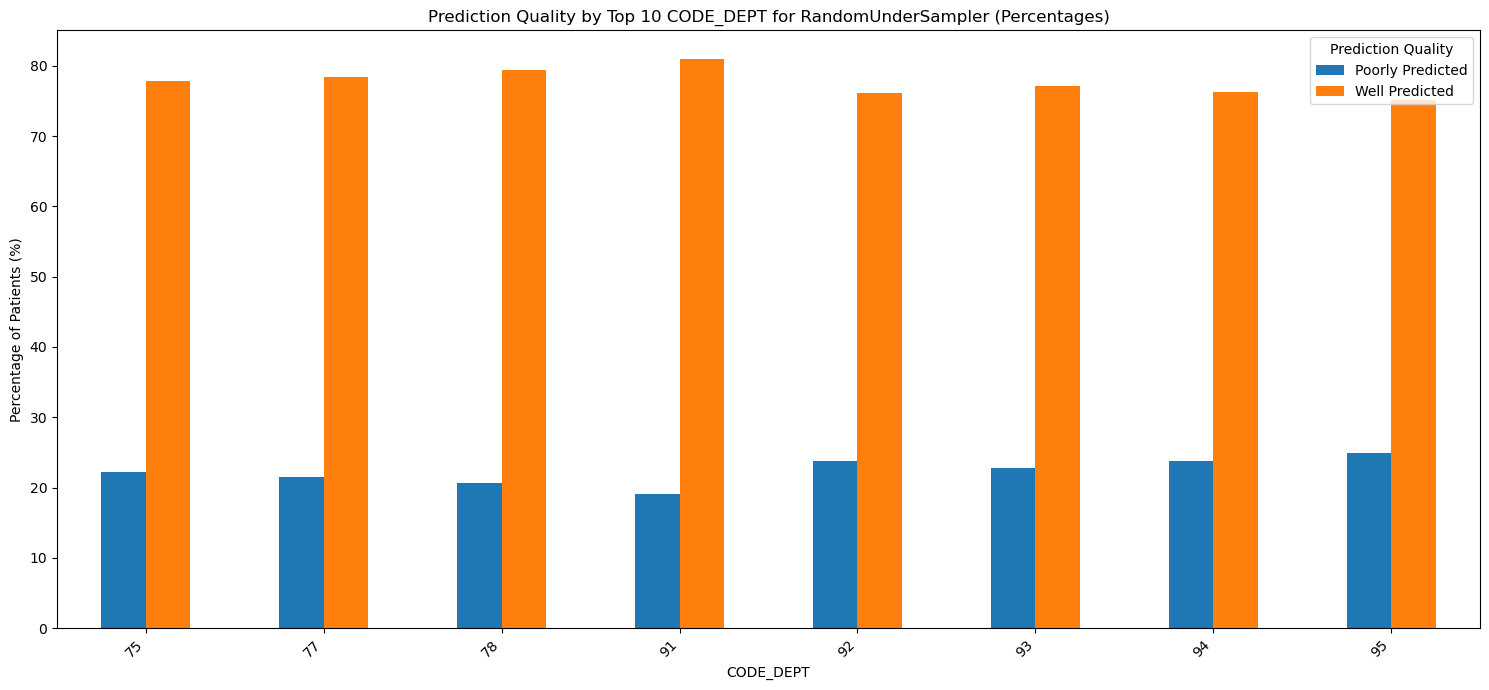


Median max_PM25_J_0 by Prediction Quality:
Prediction_Quality
Poorly Predicted    9.00
Well Predicted      9.62
Name: max_PM25_J_0, dtype: float64


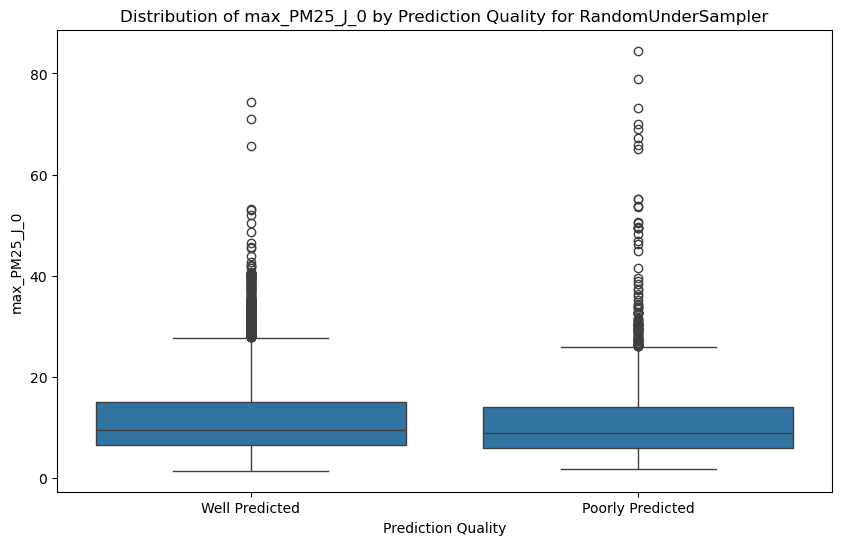


Median max_PM25_J_0 by specific Classification types (TP, TN, FP, FN):
Classification
False Negative    9.62
False Positive    9.00
True Negative     9.56
True Positive     9.81
Name: max_PM25_J_0, dtype: float64


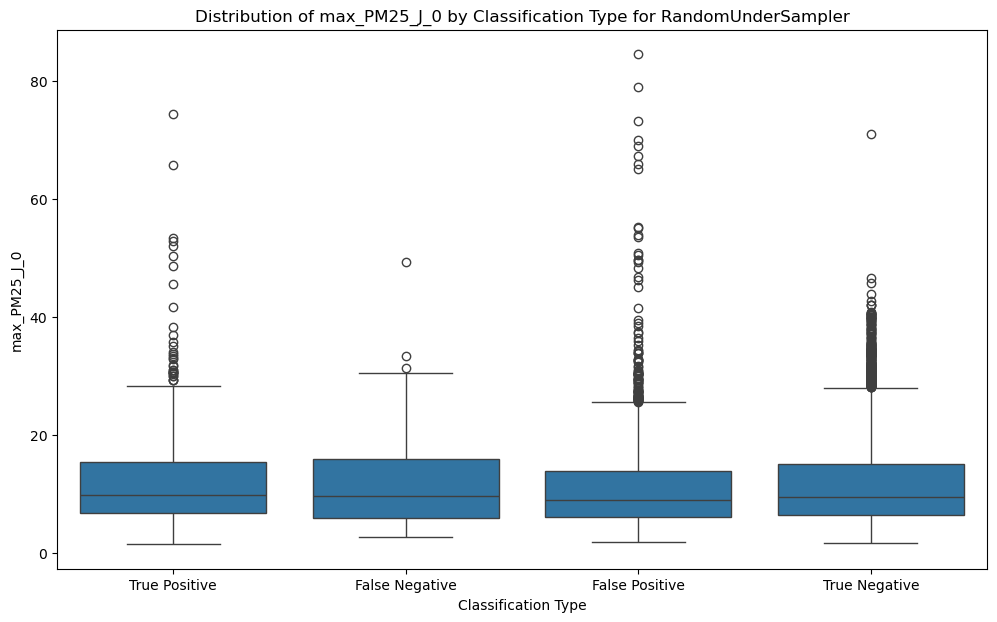


cluster Distribution by Prediction Quality (Percentages):
Prediction_Quality  Poorly Predicted  Well Predicted
cluster                                             
1.0                            27.06           72.94
2.0                            20.16           79.84
3.0                            22.53           77.47
4.0                            35.92           64.08


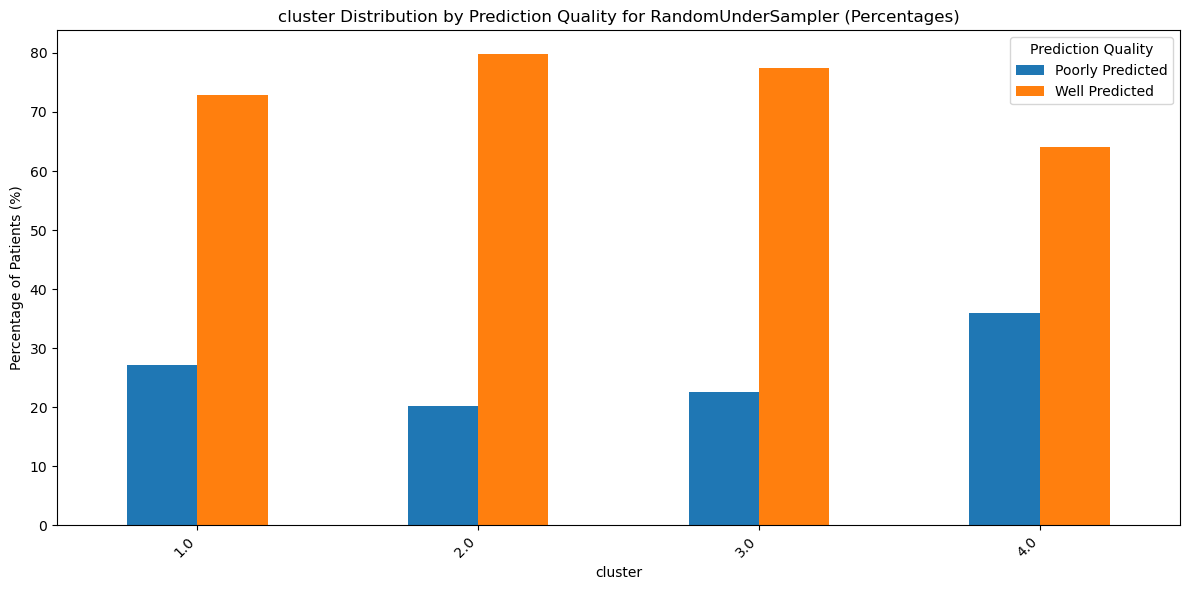


--- Analysis Complete ---


In [26]:
# Define your file paths and classifier name
json_file = r'C:\experiments\rigorous_ml\20250818_120437\all_metrics_20250818_120437.json'
patient_data_file = r'R:/Direction_Data/0_Projets/Projet_CANCAIR/2025_Projet_Loice/Data/df_patients_clusters_.csv' # REMPLACEZ CE CHEMIN !
desired_classifier = 'RandomUnderSampler' # Ou 'RandomOverSampler' ou autre nom exact

# --- Call the function ---
print(f"Starting analysis for classifier: {desired_classifier}...")
analysis_output = analyze_patient_predictions_with_df(
    df_patient_data= df_clusters,
    json_results_path=json_file,
    classifier_name=desired_classifier,
    patient_id_col_in_patient_data='pseudo_provisoire', # This is the ID column in df_my_patients
    geo_col='CODE_DEPT',
    air_quality_col='max_PM25_J_0',
    age_col='age_at_event',
    age_cat_col='cat_age',
    cluster_col='cluster'
)

print("\n--- Analysis Complete ---")
# You can now access results from the returned dictionary:
# For example, to see the merged data:
# print(analysis_output['merged_data'].head())

# To see specific summaries:
# print(analysis_output.get('overall_prediction_quality'))
# print(analysis_output.get('avg_air_quality_by_pred_quality'))

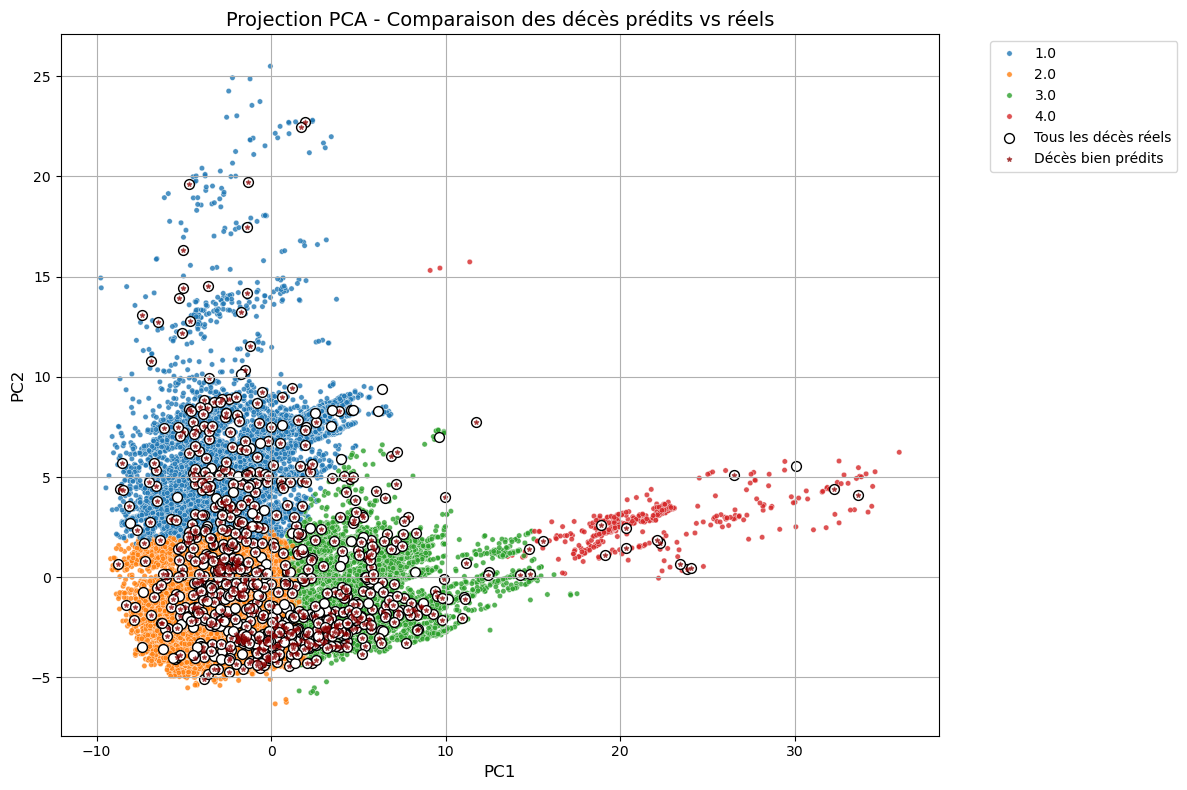

In [23]:
# --- Extraction et préparation des données ---
breakdown_data = results_ml['global'][desired_classifier]['patient_classification_breakdown']
true_positives_ids = breakdown_data.get('true_positives_patients_ids', [])
false_negatives_ids = breakdown_data.get('false_negatives_patients_ids', [])

# DataFrame de visualisation
df_visu = df_clusters.copy()
df_visu["PC1"] = df_pca["PC1"]
df_visu["PC2"] = df_pca["PC2"]

# Alignement des types
if true_positives_ids:
    if isinstance(true_positives_ids[0], int):
        df_visu['pseudo_provisoire'] = pd.to_numeric(df_visu['pseudo_provisoire'], errors='coerce')
    else:
        df_visu['pseudo_provisoire'] = df_visu['pseudo_provisoire'].astype(str)

# Classification des patients
df_visu["is_tp"] = df_visu["pseudo_provisoire"].isin(true_positives_ids)
df_visu["is_actual_death"] = df_visu["pseudo_provisoire"].isin(true_positives_ids + false_negatives_ids)

# Palette clusters
palette_custom = {
    1: '#1f77b4', 2: '#ff7f0e', 3: '#2ca02c', 4: '#d62728', 5: '#9467bd',
    6: '#8c564b', 7: '#e377c2', 8: '#7f7f7f', 9: '#bcbd22', 10: '#17becf',
    11: '#aec7e8', 12: '#ffbb78', 13: '#98df8a'
}

# --- Visualisation ---
plt.figure(figsize=(12, 8))

# Clusters de base
sns.scatterplot(data=df_visu, x="PC1", y="PC2", hue="cluster", 
                palette=palette_custom, alpha=0.8, s=15, 
                edgecolor='white', legend='full')

# Décès réels (cercles violets)
actual_deaths = df_visu[df_visu["is_actual_death"]]
plt.scatter(actual_deaths["PC1"], actual_deaths["PC2"], 
           color="white", edgecolor="black", s=50, 
           marker='o', label="Tous les décès réels")

# Décès bien prédits (cercles rouges plus grands)
tp_deaths = df_visu[df_visu["is_tp"]]
plt.scatter(tp_deaths["PC1"], tp_deaths["PC2"],
           color="darkred", edgecolor="darkred", s=10, alpha =  0.6,
           marker='*', label="Décès bien prédits")

# Finitions
plt.title("Projection PCA - Comparaison des décès prédits vs réels", fontsize=14)
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.grid(True)

# Légende complète
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()